# Customer Lifetime Value (CLV) Feature Engineering

## Objective
Create a proxy-based CLV score and prepare features for value-based customer segmentation.

## Dataset
IBM Telco Customer Churn dataset (adapted for SME context)

## CLV Feature Construction

In [2]:
import pandas as pd

# Load dataset
df = pd.read_csv("../data/raw/telco_customer_churn.csv")

df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# Create retention factor
df['retention_factor'] = df['Churn'].map({'No': 1, 'Yes': 0})

df[['Churn', 'retention_factor']].head()

,Churn,retention_factor
0,No,1
1,No,1
2,Yes,0
3,No,1
4,Yes,0


In [4]:
# Compute CLV score
df['clv_score'] = (
    df['MonthlyCharges'] *
    df['tenure'] *
    df['retention_factor']
)

df[['MonthlyCharges', 'tenure', 'retention_factor', 'clv_score']].head()

,MonthlyCharges,tenure,retention_factor,clv_score
0,29.85,1,1,29.85
1,56.95,34,1,1936.30
2,53.85,2,0,0.00
3,42.30,45,1,1903.50
4,70.70,2,0,0.00


In [5]:
df['clv_score'].describe()

count    7043.000000
mean     1873.138513
std      2291.322438
min         0.000000
25%         0.000000
50%       855.000000
75%      3195.325000
max      8550.000000
Name: clv_score, dtype: float64

In [8]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'retention_factor', 'clv_score'],
      dtype='object')

In [9]:
# --------------------------------------------------
# Service Count Feature (required for segmentation)
# --------------------------------------------------

service_cols = [
    'PhoneService',
    'InternetService',
    'OnlineSecurity',
    'OnlineBackup',
    'DeviceProtection',
    'TechSupport',
    'StreamingTV',
    'StreamingMovies'
]

df['service_count'] = df[service_cols].apply(
    lambda row: sum(row == 'Yes'),
    axis=1
)

df[['service_count']].describe()

,service_count
count,7043.000000
mean,2.941076
std,1.843899
min,0.000000
25%,1.000000
50%,3.000000
75%,4.000000
max,7.000000


## 3.5 Feature Preparation for Segmentation

We prepare a standardized feature matrix for customer segmentation using behavioral and value-based features.

Selected features:
- `tenure` → customer longevity
- `MonthlyCharges` → current revenue intensity
- `service_count` → product engagement depth
- `clv_score` → long-term customer value proxy

In [10]:
# Select features for segmentation
segmentation_features = [
    'tenure',
    'MonthlyCharges',
    'service_count',
    'clv_score'
]

df_segment = df[segmentation_features].copy()

df_segment.head()

,tenure,MonthlyCharges,service_count,clv_score
0,1,29.85,1,29.85
1,34,56.95,3,1936.30
2,2,53.85,3,0.00
3,45,42.30,3,1903.50
4,2,70.70,1,0.00


In [11]:
df_segment.describe()

,tenure,MonthlyCharges,service_count,clv_score
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2.941076,1873.138513
std,24.559481,30.090047,1.843899,2291.322438
min,0.000000,18.250000,0.000000,0.000000
25%,9.000000,35.500000,1.000000,0.000000
50%,29.000000,70.350000,3.000000,855.000000
75%,55.000000,89.850000,4.000000,3195.325000
max,72.000000,118.750000,7.000000,8550.000000


In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_segment)

X_scaled.shape

(7043, 4)

In [14]:
import pandas as pd

X_scaled_df = pd.DataFrame(
    X_scaled,
    columns=segmentation_features,
    index=df.index
)

X_scaled_df.head()

,tenure,MonthlyCharges,service_count,clv_score
0,-1.277445,-1.160323,-1.052777,-0.804522
1,0.066327,-0.259629,0.031958,0.027567
2,-1.236724,-0.362660,0.031958,-0.817550
3,0.514251,-0.746535,0.031958,0.013252
4,-1.236724,0.197365,-1.052777,-0.817550


## 4. Customer Segmentation (CLV-Based)

We segment customers using behavioral and value-based features to identify distinct customer groups with different lifetime value and engagement patterns.

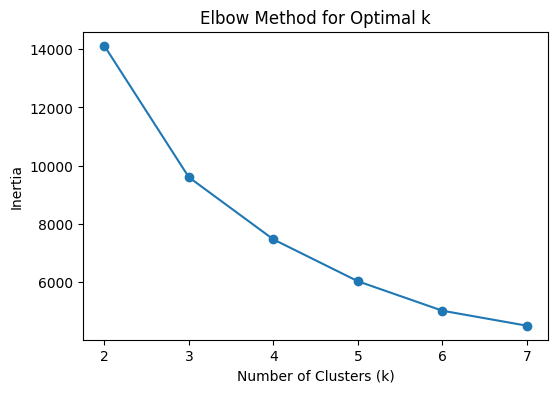

In [15]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []

K = range(2, 8)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

Insight: The elbow curve suggests diminishing returns beyond k = 3–4 clusters. We proceed with k = 3 for clear business interpretability.

In [16]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

df_segment['segment'] = cluster_labels
df_segment['segment'].value_counts()

segment
2    2833
1    2255
0    1955
Name: count, dtype: int64

In [17]:
segment_profile = (
    df_segment
    .groupby('segment')
    .agg({
        'clv_score': 'mean',
        'tenure': 'mean',
        'MonthlyCharges': 'mean',
        'service_count': 'mean'
    })
    .round(2)
)

segment_profile


,clv_score,tenure,MonthlyCharges,service_count
segment,,,,
0,5037.68,59.58,89.33,4.99
1,677.51,27.32,27.33,1.14
2,641.04,17.62,77.61,2.96


### Segment Insights

- Segment 0: High CLV, long tenure, high service adoption → Core loyal customers
- Segment 1: Medium CLV, moderate tenure → Growth segment with upsell potential
- Segment 2: Low CLV, short tenure, low service usage → High-risk / low-value customers

These segments enable differentiated retention and monetization strategies.